### Relevant library

In [1]:
using PyPlot, Optim, Logging
Logging.configure(level=DEBUG, filename="GP-recovery.log")
push!(LOAD_PATH, "../src")
using GP

### Interpolating individual neuron's tuning curve from training data

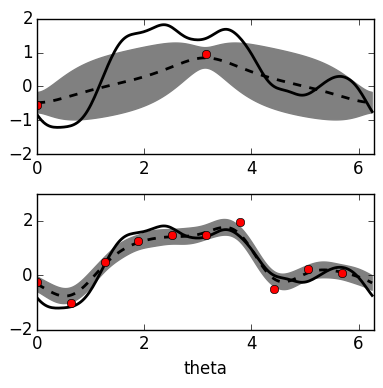

In [2]:
Δ = 1.0 # smoothness
ker = Kernel(Δ) # kernel object

res = 199 # resolution of the generated random functions
θs, xs = tc(res, 1, ker) # generate the true tuning curve

Ps = [2, 10] # number of samples for the trianing data
σn = sqrt(0.1) # observational noise's std
# rs = xs + randn(size(xs)) * σn # noisy training data

figure(figsize=(4, 4))
for (ixP, P) in enumerate(Ps)
    # angles of the training data
    θs_data = θs[1:round(Int64, ceil(res / P)):end]
    # training data
    rs_data = xs[1:round(Int64, ceil(res / P)):end, :] + randn(P, 1) * σn
    
    # interpolation needs the noise covariance of the training data
    Cn = σn^2 * eye(P)
    # mean and variance of the interpolated function at full resolution
    xs_infer, σs_infer = tc_interp_uniform(rs_data, θs, ker; Cn=Cn)
    
    # plot the interpolated tuning curve
    subplot(2, 1, ixP)
    PyPlot.locator_params(nbins=4)
    # interpolated mean
    plot(θs, xs_infer, "k--", linewidth=2)
    # uncertainty
    PyPlot.fill_between(θs, xs_infer[:, 1] - σs_infer[:, 1], xs_infer[:, 1] + σs_infer[:, 1], color="grey")
    # true tuning curve
    plot(θs, xs[:, 1], "k-", linewidth=2)
    # training data
    plot(θs_data, rs_data[:, 1], "ro")

    xlim([0, 2π]);
end
xlabel("theta")
tight_layout()

### Theoretical recovery performances

In [3]:
# computes the exact R2 by summing over the frequencies
function R2(Δ, P, snr)
    s = 0.0
    for p in 0:(P-1)
        n = tanh(Δ/2)^2 / sinh(Δ * P) * cosh(Δ * (2p - P))
        d = tanh(Δ/2) / sinh(Δ * P / 2) * cosh(Δ*p - Δ * P / 2) + 1/(P * snr)
        if ~isnan(n / d)
            s += n / d
        end
    end
    return s
end

# approximation when P << NTC
function R2_approx(Δ, P, snr)
    return (P / (4/Δ)) / (1 + 1/snr)
end

R2_approx (generic function with 1 method)

### Simulations versus theory under different SNRs and NTCs

In [4]:
# start workers
if length(workers()) > 1
    rmprocs(workers()[2:end])
end
addprocs(11)
@everywhere push!(LOAD_PATH, "../src/")
@everywhere using GP

In [5]:
# simulation parameters
ntrial = 10
M = 100
Ps = round(Int64, logspace(log10(2), log10(500), 10))
Ptest = 100
snrs = [0.5, 1, 2]
Δs = [1/2, 1/4, 1/8];

In [6]:
# theoretical answers
theory = Float64[R2(Δ, P, snr)
                for P in Ps, snr in snrs, Δ in Δs];
theory_approx = Float64[R2_approx(Δ, P, snr)
                for P in Ps, snr in snrs, Δ in Δs];

In [7]:
# running simulations
sim = SharedArray(Float64, length(Ps), length(snrs), length(Δs), ntrial)
for (ix, Δ) in enumerate(Δs)
    ker = Kernel(Δ)
    for (ixsnr, snr) in enumerate(snrs)
        debug("ix: $ix, ixsnr: $ixsnr")
        σn = 1 / sqrt(snr)
        for (ixP, P) in enumerate(Ps)
            @sync @parallel for ixtrial in 1:ntrial
                # training stimulus
                θtrain = linspace(0, 2π, P + 1)[1:P]
                # testing stimulus
                θtest = rand(Ptest) * 2π
                # noiseless response of the population during both training and testing
                x = GP.tc2([θtrain; θtest], M, ker)
                xtrain, xtest = x[1:P, :], x[(P+1):end, :]
                # noisy responses
                rtrain = xtrain + randn(size(xtrain)) * σn
                                
                # inverse covraince matrix of the training data
                Cinv = inv_cov_uniform(P, ker; σn=σn)
                # cross covariance between training and testing
                Pmat = GP.val(θtest .- θtrain', ker)
                
                # recovered noiseless test responose
                xtest_hat = Pmat * Cinv * rtrain
                # store the error
                sim[ixP, ixsnr, ix, ixtrial] = mean((xtest_hat .- xtest)[:].^2)
            end
        end
    end
end

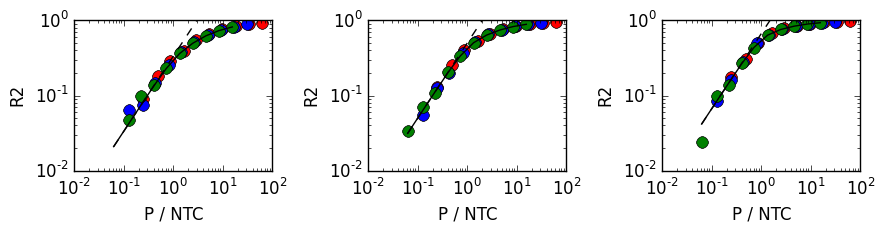

In [8]:
# plot the performance separately for different SNRs
colors = ["r", "b", "g"]
figure(figsize=(9, 2.5))
for (ixsnr, snr) in enumerate(snrs)
    subplot(1, 3, ixsnr)
    # plot the simulated data
    for (ix, Δ) in enumerate(Δs)
        c = colors[ix]
        plot(Ps / 4 * Δ, 1 - vec(mean(sim[:, ixsnr, ix, :], 4)), c * "o", markersize=8)
    end
    
    # plot the exact
    plot(Ps / 4 * Δs[end], vec(theory[:, ixsnr, end]), "k-")
    # and approximate theory
    plot(Ps / 4 * Δs[end], vec(theory_approx[:, ixsnr, end]), "k--")
    
    ylim([1e-2, 1]); yscale("log"); xscale("log")
    xlabel("P / NTC"); ylabel("R2")
end
tight_layout()

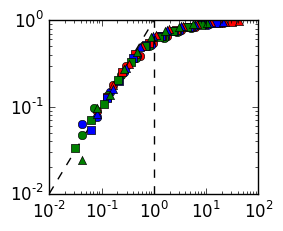

In [9]:
# collapse everythingh onto the same curve with R2 normalized by infinite data limit
# and x axis normalized by the trainsidion number of trials
colors = ["r", "b", "g"]
symbols = ["o", "s", "^"]

figure(figsize=(3, 2.5))
# low P limit
plot([0.01, 1], [0.01, 1], "k--")
for (ixsnr, snr) in enumerate(snrs)
    for (ix, Δ) in enumerate(Δs)
        # color and symbol
        c, s = colors[ix], symbols[ixsnr]
        # normalized number of trials
        Pnorm = Ps / 4 * Δ / (1 + 1/snr)
        # normalized recovery performance
        R2norm = 1 - vec(mean(sim[:, ixsnr, ix, :], 4))
        
        plot(Pnorm, R2norm, c * s, markersize=6)
        ylim([1e-2, 1]); xlim([1e-2, 1e2]); yscale("log"); xscale("log")
    end
end

PyPlot.axvline(1, linestyle="--", color="k")
tight_layout()

### Simulations versus theory in the P vs SNR plane

In [12]:
# parameters
Ps = round(Int64, logspace(log10(2), log10(500), 20))
ntrial, M, Ptest, Δ = 10, 100, 100, 1/4
snrs = logspace(-2, 2, 20)
ker = Kernel(Δ)

GP.Kernel(0.25)

In [13]:
theory = Float64[R2(Δ, P, snr)
                for P in Ps, snr in snrs]
sim = SharedArray(Float64, length(Ps), length(snrs), ntrial)
for (ixP, P) in enumerate(Ps)
    debug("ixP: $ixP")
    for ixsnr in 1:length(snrs)
        snr = snrs[ixsnr]
        σn=1 / sqrt(snr)
        @sync @parallel for ixtrial in 1:ntrial
            θtrain = linspace(0, 2π, P + 1)[1:P]
            θtest = rand(Ptest) * 2π
            x = GP.tc2([θtrain; θtest], M, ker)
            xtrain, xtest = x[1:P, :], x[(P+1):end, :]
            rtrain = xtrain + randn(size(xtrain)) * σn
            Cinv = inv_cov_uniform(P, ker; σn=σn)
            Pmat = GP.val(θtest .- θtrain', ker)

            xtest_hat = Pmat * Cinv * rtrain
            sim[ixP, ixsnr, ixtrial] = mean((xtest_hat .- xtest)[:].^2)
        end
    end
end

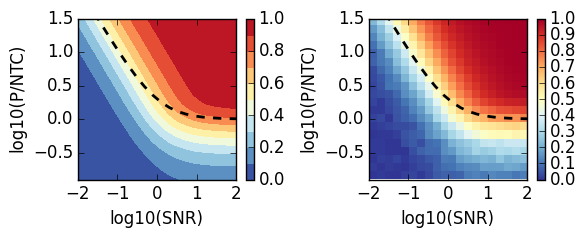

In [30]:
Psnorm = Ps/4*Δ

figure(figsize=(6, 2.5))

# theoretical recovery performance
subplot(121)
PyPlot.locator_params(nbins=5)
contourf(log10(snrs), log10(Psnorm), theory, nchunk=15, cmap="RdYlBu_r",
        levels=linspace(0, 1, 11))
plot(log10(snrs), log10(1+1./snrs), "k--", linewidth=2)
xlim(extrema(log10(snrs))); ylim(extrema(log10(Psnorm)))
xlabel("log10(SNR)"); ylabel("log10(P/NTC)")
colorbar()
    
# actual recovery performance
subplot(122)
PyPlot.locator_params(nbins=5)
extent = [extrema(log10(snrs))..., extrema(log10(Psnorm))...]
imshow(1 - squeeze(mean(sim, 3), 3), vmin=0, vmax=1,
        origin="lower", aspect="auto", cmap="RdYlBu_r",
        extent=[extrema(log10(snrs))..., extrema(log10(Psnorm))...], interpolation="nearest")
plot(log10(snrs), log10(1+1./snrs), "k--", linewidth=2)
xlim(extrema(log10(snrs))); ylim(extrema(log10(Psnorm)))
xlabel("log10(SNR)"); ylabel("log10(P/NTC)")
colorbar()

tight_layout()